In [222]:
# Import libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from census import Census
from us import states
import json
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

In [2]:
# Read in dataframe.
hospital_referrals = pd.read_csv('data/hospital_referrals.csv')

In [3]:
# Create grouped series by referring npis and transaction count and patient count.
density_transaction_count = (
    hospital_referrals\
    .groupby('provider_npi')['referrals']\
    .mean()\
    .sort_values(ascending = False)
)

density_patient_count = (
    hospital_referrals\
    .groupby('provider_npi')['number_of_patients']\
    .mean()\
    .sort_values(ascending = False)
)

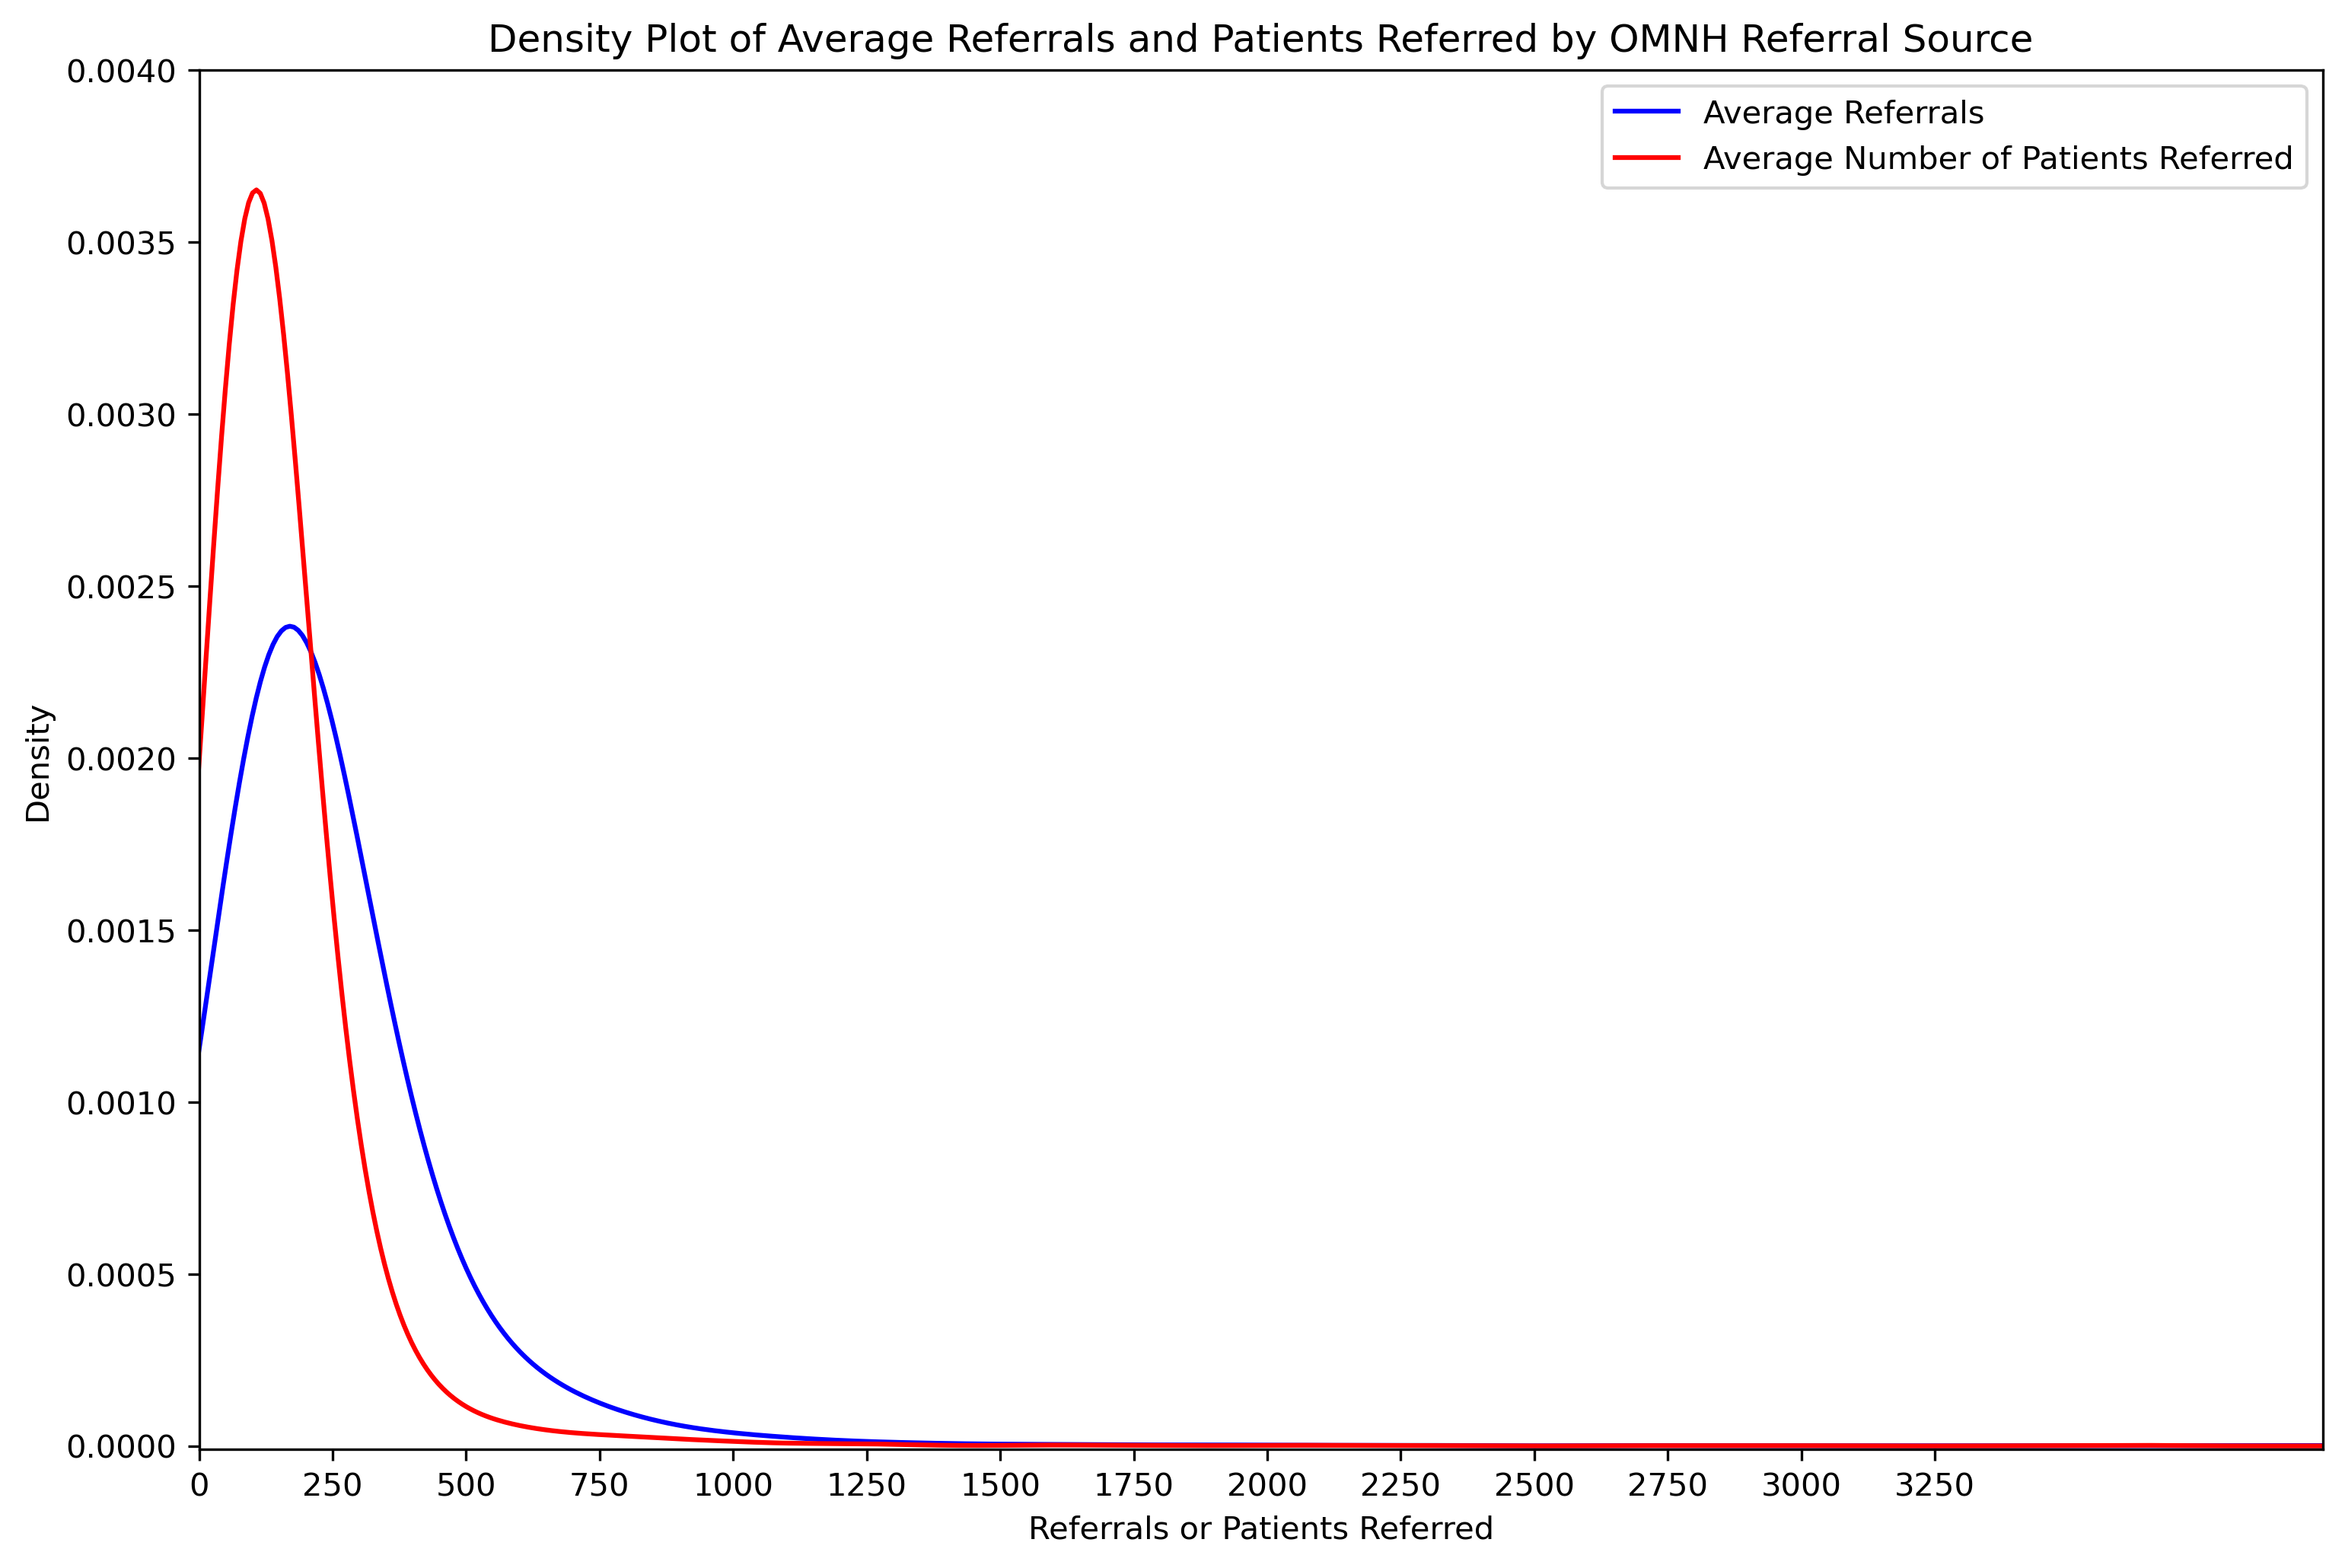

In [4]:
# Plot distributions of patient counts and referral counts.
ymin = -0.00001
ymax = 0.004
plt.figure(figsize = (12, 8), dpi = 300)
density_transaction_count.plot(kind = 'density', bw_method = 0.5, color = 'b')
density_patient_count.plot(kind = 'density', bw_method = 0.5, color = 'r')
plt.xlim(0, max(density_transaction_count))
plt.xticks(np.arange(0,3500,250))
plt.ylim(bottom = ymin, top = ymax)
plt.xlabel("Referrals or Patients Referred")
plt.title('Density Plot of Average Referrals and Patients Referred by OMNH Referral Source')
plt.legend(labels = ['Average Referrals','Average Number of Patients Referred'])
plt.show();

In [5]:
# Obtain top 20 referral specialties from the patient count and referral count series.
transaction_specialty_count = (
    pd.DataFrame(density_transaction_count[density_transaction_count >= 500].reset_index())\
.merge(hospital_referrals.loc[:, hospital_referrals.columns != 'referrals'])\
.rename(columns = {'referrals':'average_referrals'})\
.value_counts('provider_taxonomy_code_display_name')[:20]\
    .to_frame()\
    .reset_index()\
    .rename(columns = {0: 'Count'})\
    .sort_values('Count')
)

patient_specialty_count = (
    pd.DataFrame(density_patient_count[density_patient_count >= 500].reset_index())\
.merge(hospital_referrals.loc[:, hospital_referrals.columns != 'number_of_patients'])\
.rename(columns = {'number_of_patients':'average_number_of_patients'})\
.value_counts('provider_taxonomy_code_display_name')[:20]\
    .to_frame()\
    .reset_index()\
    .rename(columns = {0: 'Count'})\
    .sort_values('Count')
)

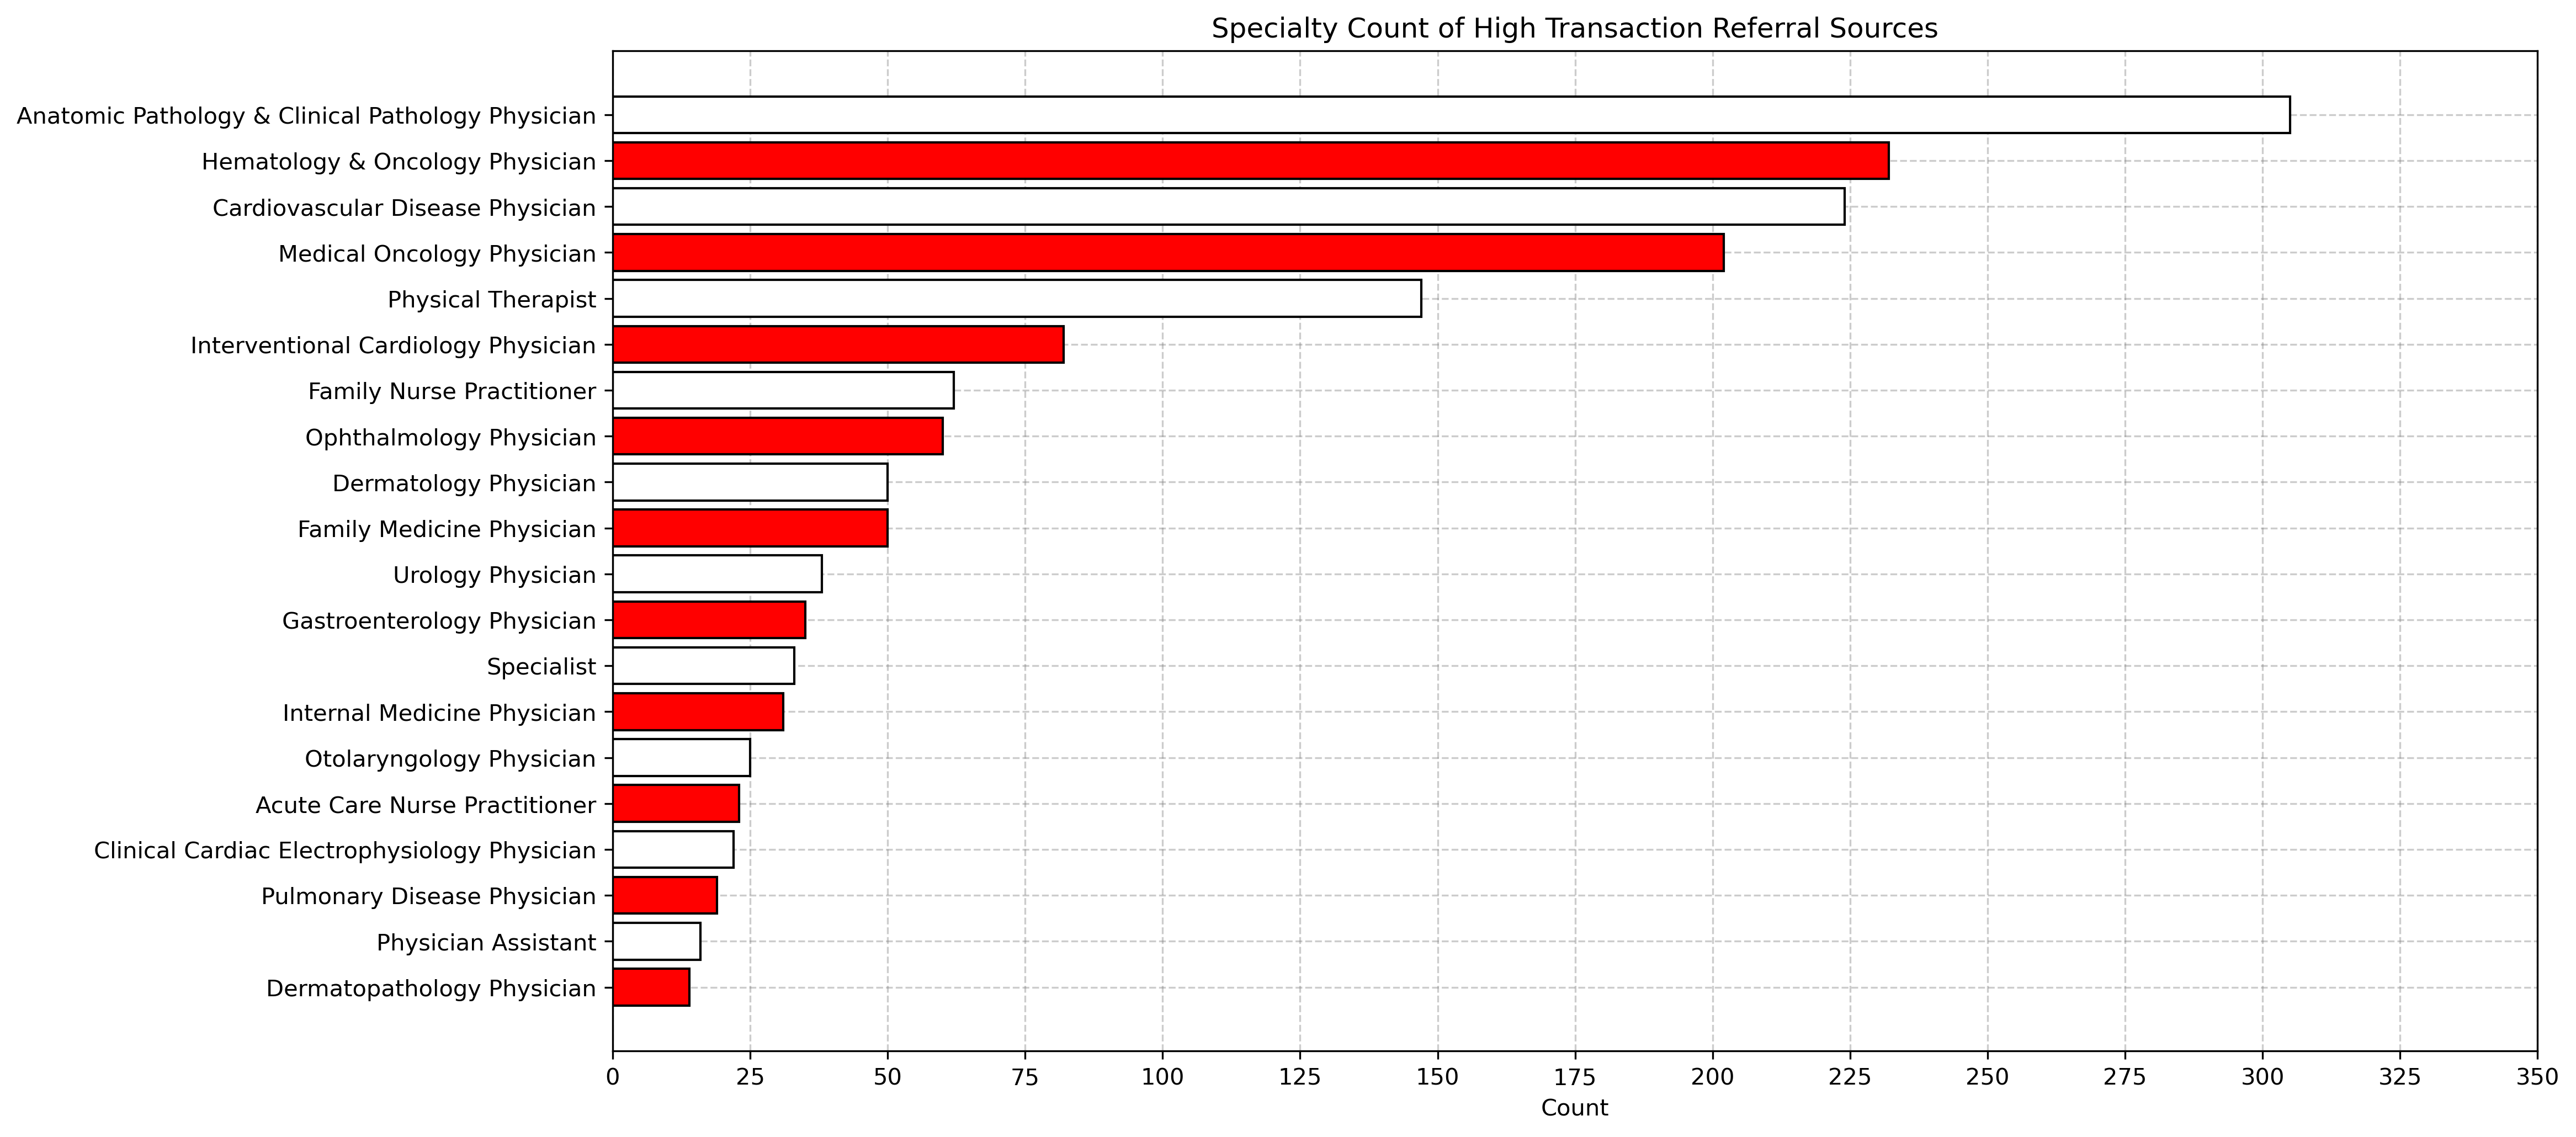

In [6]:
# Then plot counts with barplots.
# Consider removing nurse practitioners/nurses and adding specialties on same level.
fig, ax = plt.subplots(figsize = (15, 8), dpi = 300)
ax.barh(y = transaction_specialty_count['provider_taxonomy_code_display_name'].str.title(),
        width = transaction_specialty_count['Count'],
        edgecolor = 'k',
        color = ['red','white'])
ax.set_axisbelow(True)
ax.grid(color = 'gray', linestyle = '--', alpha = 0.4)
plt.xlim(0,350)
plt.xticks(np.arange(0,375,25))
plt.title('Specialty Count of High Transaction Referral Sources')
plt.xlabel('Count')
plt.show();

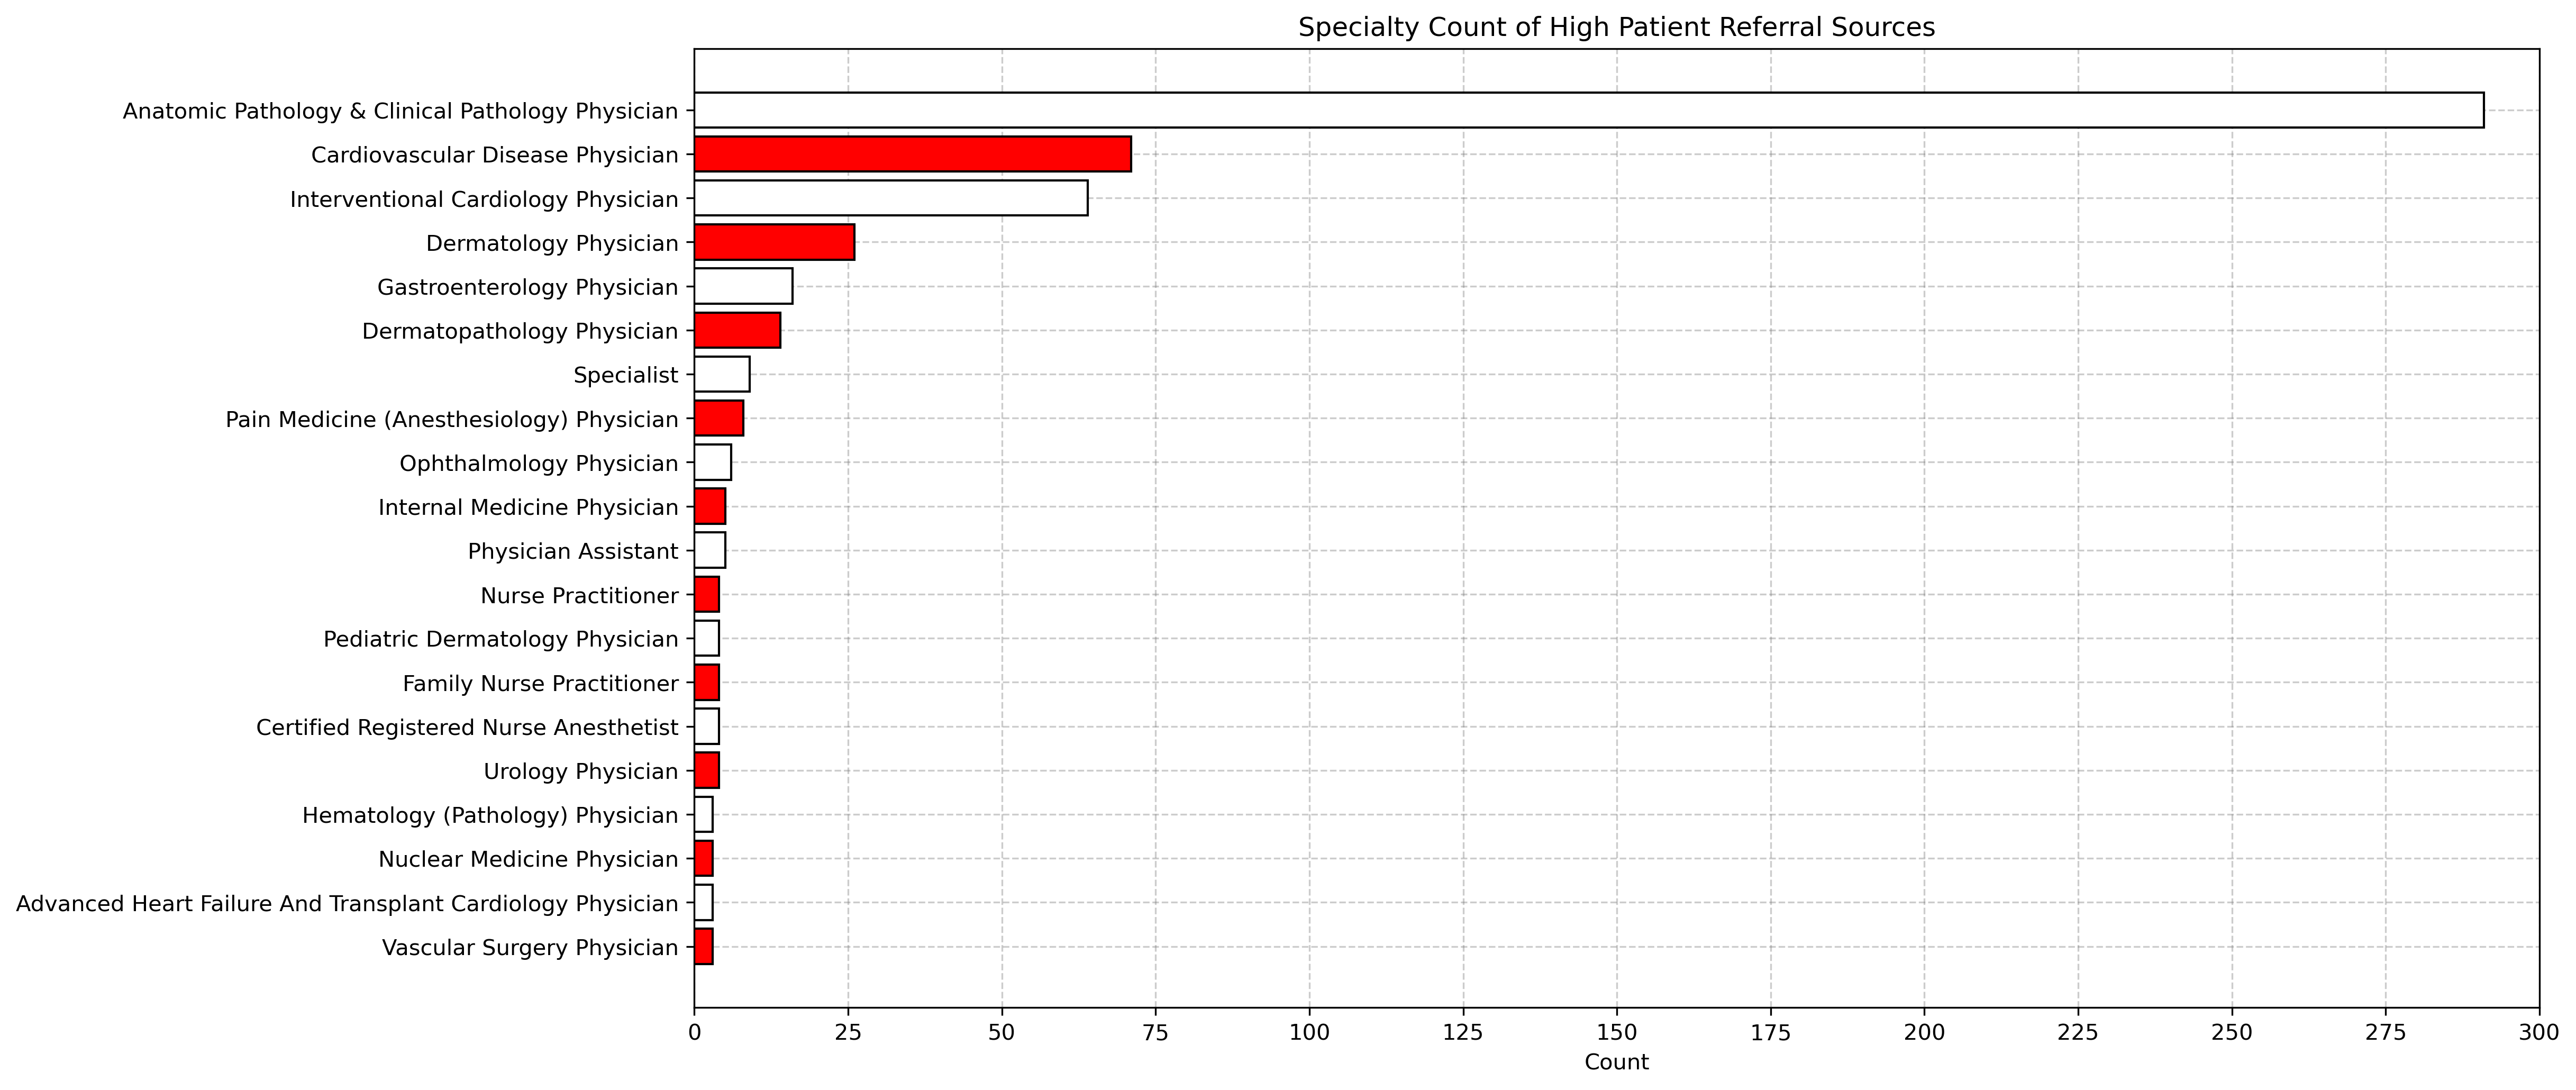

In [7]:
fig, ax = plt.subplots(figsize = (15, 8), dpi = 300)
ax.barh(y = patient_specialty_count['provider_taxonomy_code_display_name'].str.title(),
        width = patient_specialty_count['Count'],
        edgecolor = 'k',
        color = ['red','white'])
ax.set_axisbelow(True)
ax.grid(color = 'gray', linestyle = '--', alpha = 0.4)
plt.xlim(0,300)
plt.xticks(np.arange(0,325,25))
plt.title('Specialty Count of High Patient Referral Sources')
plt.xlabel('Count')
plt.show();

In [8]:
# Create dataframe for log-transformed transaction counts and patient counts.
hexbin_df = (
    density_transaction_count\
    .reset_index()\
    .merge(density_patient_count\
           .reset_index())[['referrals','number_of_patients']]\
    .assign(transaction_count = lambda df: df.apply(lambda x: np.log10(x['referrals']), axis = 1),
          patient_count = lambda df: df.apply(lambda x: np.log10(x['number_of_patients']), axis = 1))
)

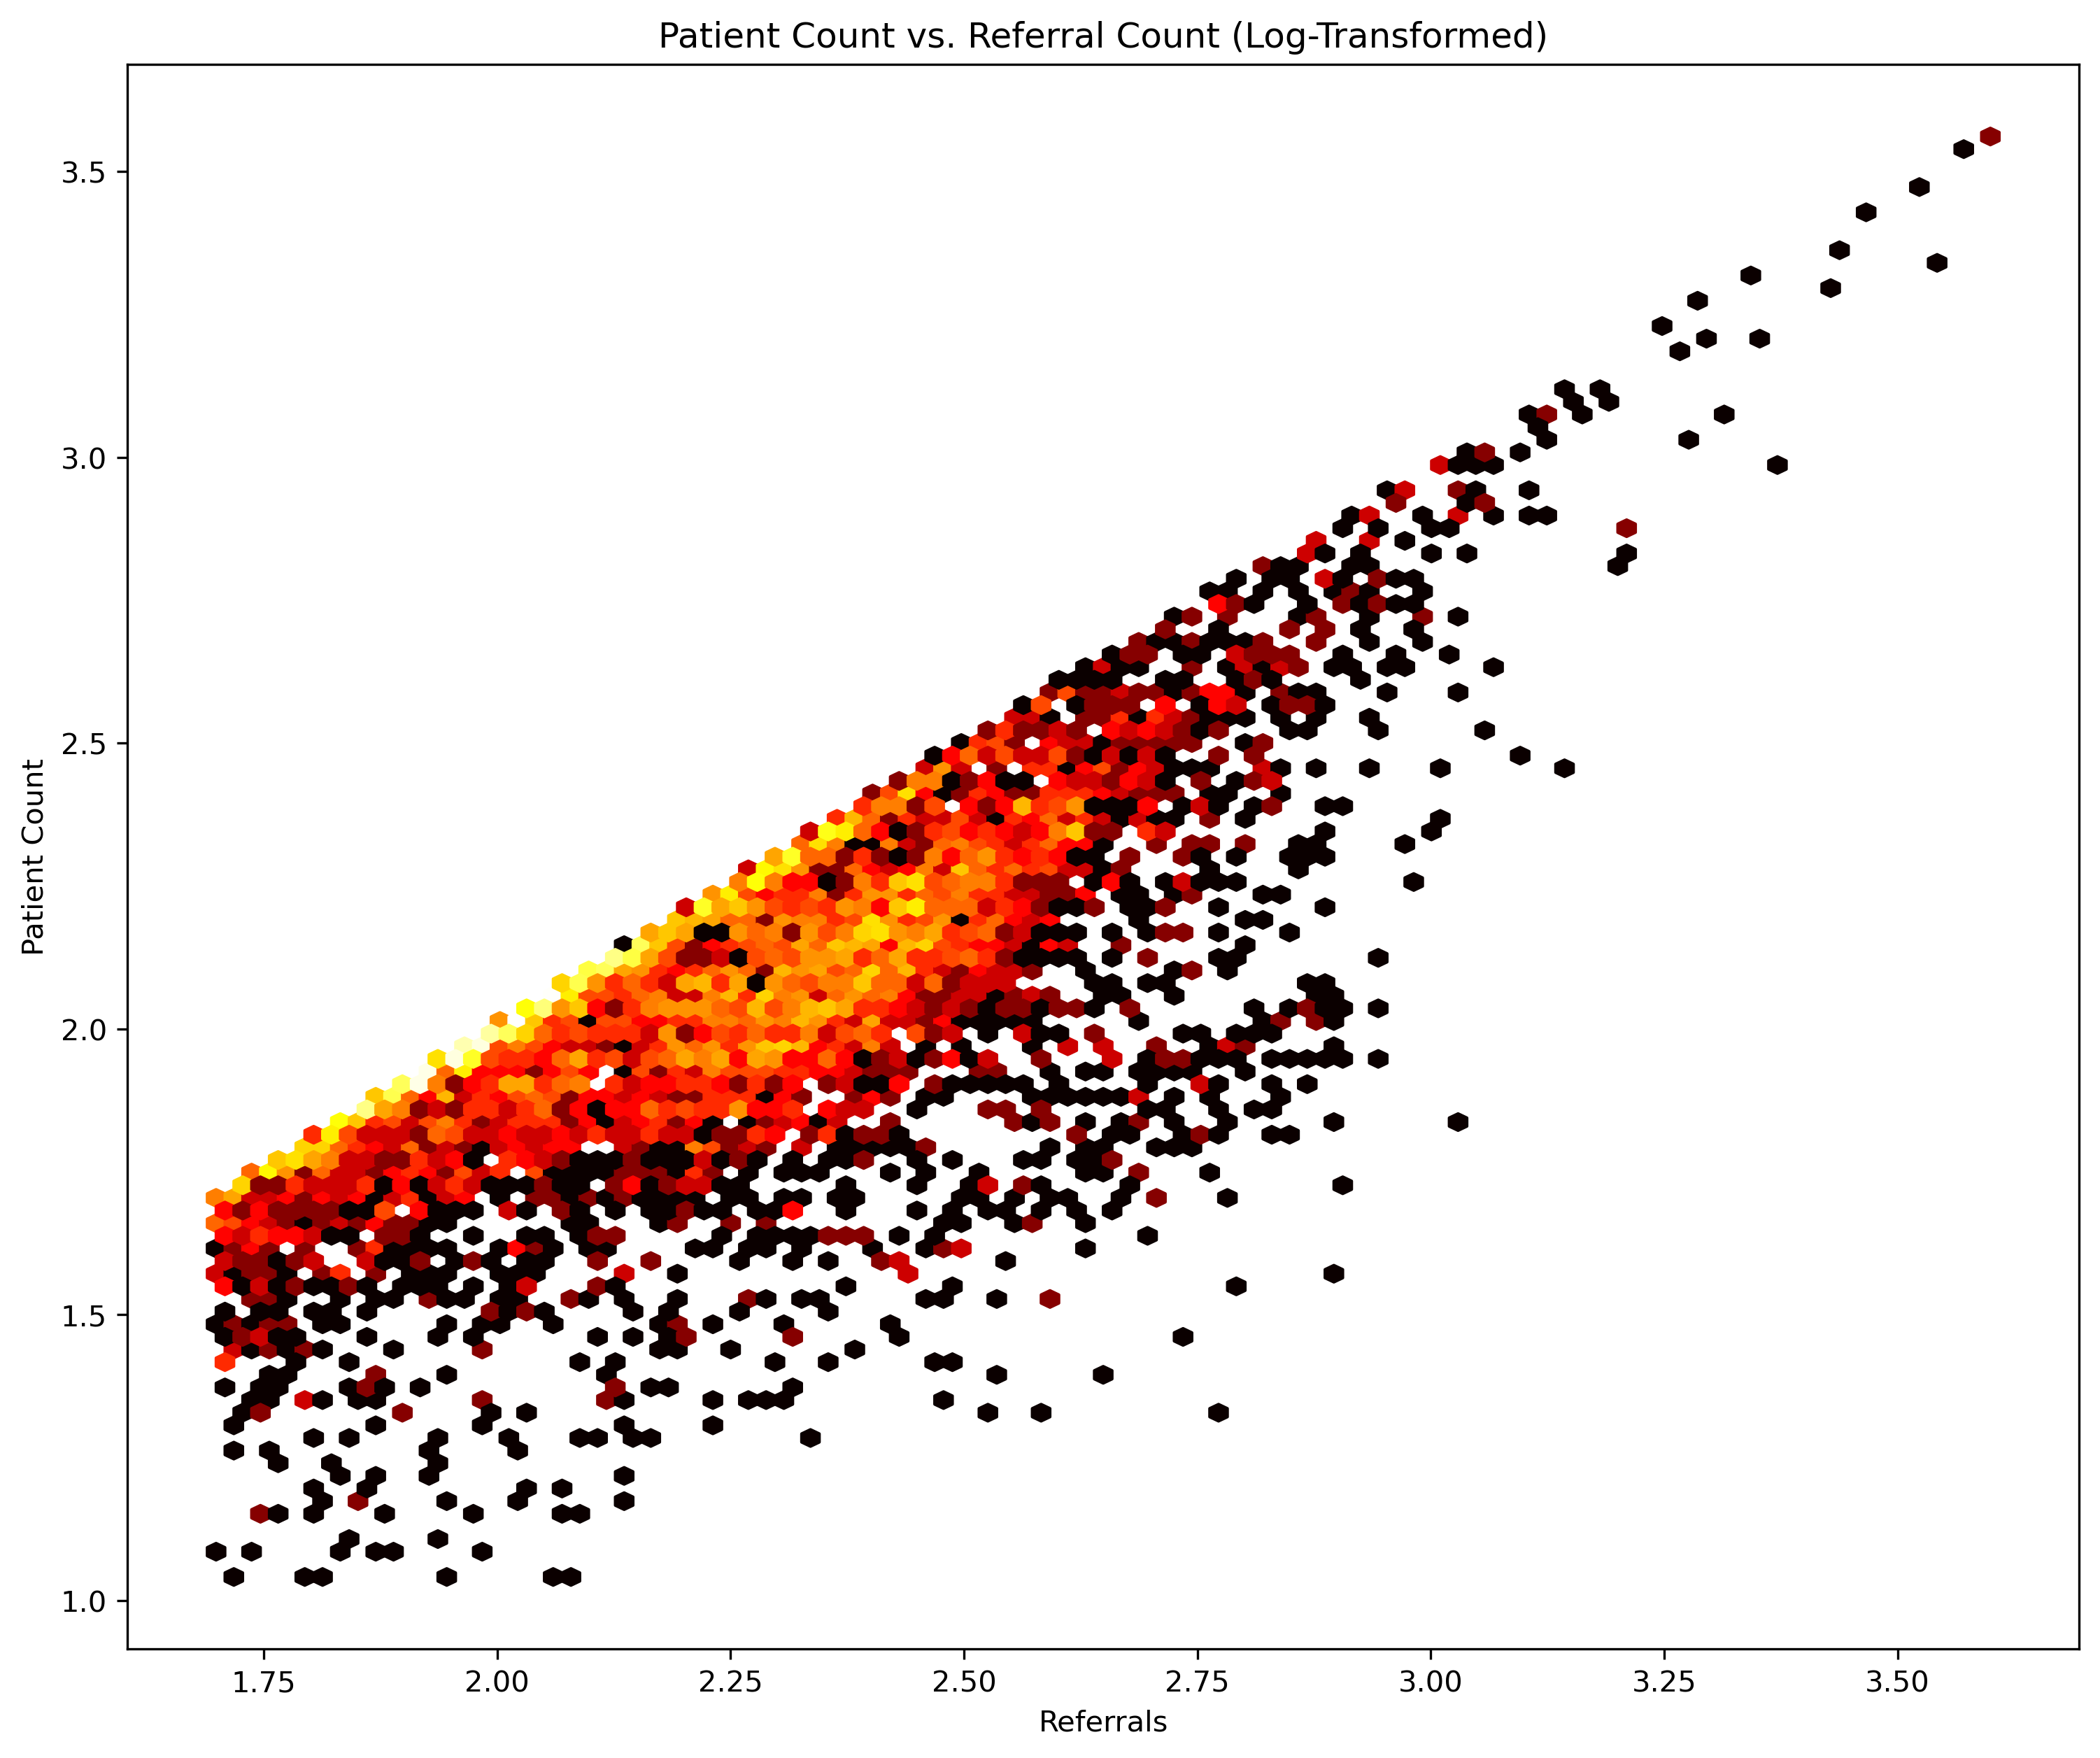

In [9]:
# Plot hexbin graph with transaction counts and patient counts showing almost perfect correlation.
plt.figure(figsize = (12,10), dpi = 300)
plt.hexbin(hexbin_df['transaction_count'],
          hexbin_df['patient_count'],
          cmap = 'hot',
          bins = 'log')
plt.title('Patient Count vs. Referral Count (Log-Transformed)')
plt.xlabel('Referrals')
plt.ylabel('Patient Count')
plt.show()

In [10]:
# Generate zipcodes of facilities and compare referrals to facilitiees by zipcode against the number of unique facilities
# in that zipcode weighted by zipcode population.
with open('data/census.json', 'r') as myfile:
    data = myfile.read()
api_key = json.loads(data)

c = Census(api_key['api_key'])
zip_data = c.acs5.state_zipcode(('NAME','B01003_001E'), states.TN.fips, zcta = '*')
zipcode_pop = (
    pd.DataFrame\
    .from_records(zip_data)[['B01003_001E','zip code tabulation area']]\
    .rename(columns = {'B01003_001E':'population',
                      'zip code tabulation area':'zipcode'})\
)

zipcode_pop['zipcode'] = zipcode_pop['zipcode'].astype(str)

hospital_referrals['facility_city_zipcode'] = hospital_referrals['facility_address'].str.extract('(\\d{5})')

referrals_and_facilities_by_zipcode = (
    pd.merge(hospital_referrals\
             .groupby('facility_city_zipcode')['referrals']\
             .sum()\
             .reset_index(),
             hospital_referrals\
             .groupby('facility_city_zipcode')['facility_entity_name']\
             .nunique()\
             .reset_index(),
             on = 'facility_city_zipcode')\
    .merge(zipcode_pop,
           left_on = 'facility_city_zipcode',
           right_on = 'zipcode')\
    .rename(columns = {'facility_entity_name':'facility_count',
                      'referrals':'total_referrals'})\
    .iloc[:,0:4]
)

referrals_and_facilities_by_zipcode['total_referrals'] = (
    referrals_and_facilities_by_zipcode['total_referrals']/referrals_and_facilities_by_zipcode['population'] * 1000
)

referrals_and_facilities_by_zipcode['facility_count'] = (
    referrals_and_facilities_by_zipcode['facility_count']/referrals_and_facilities_by_zipcode['population'] * 1000
)

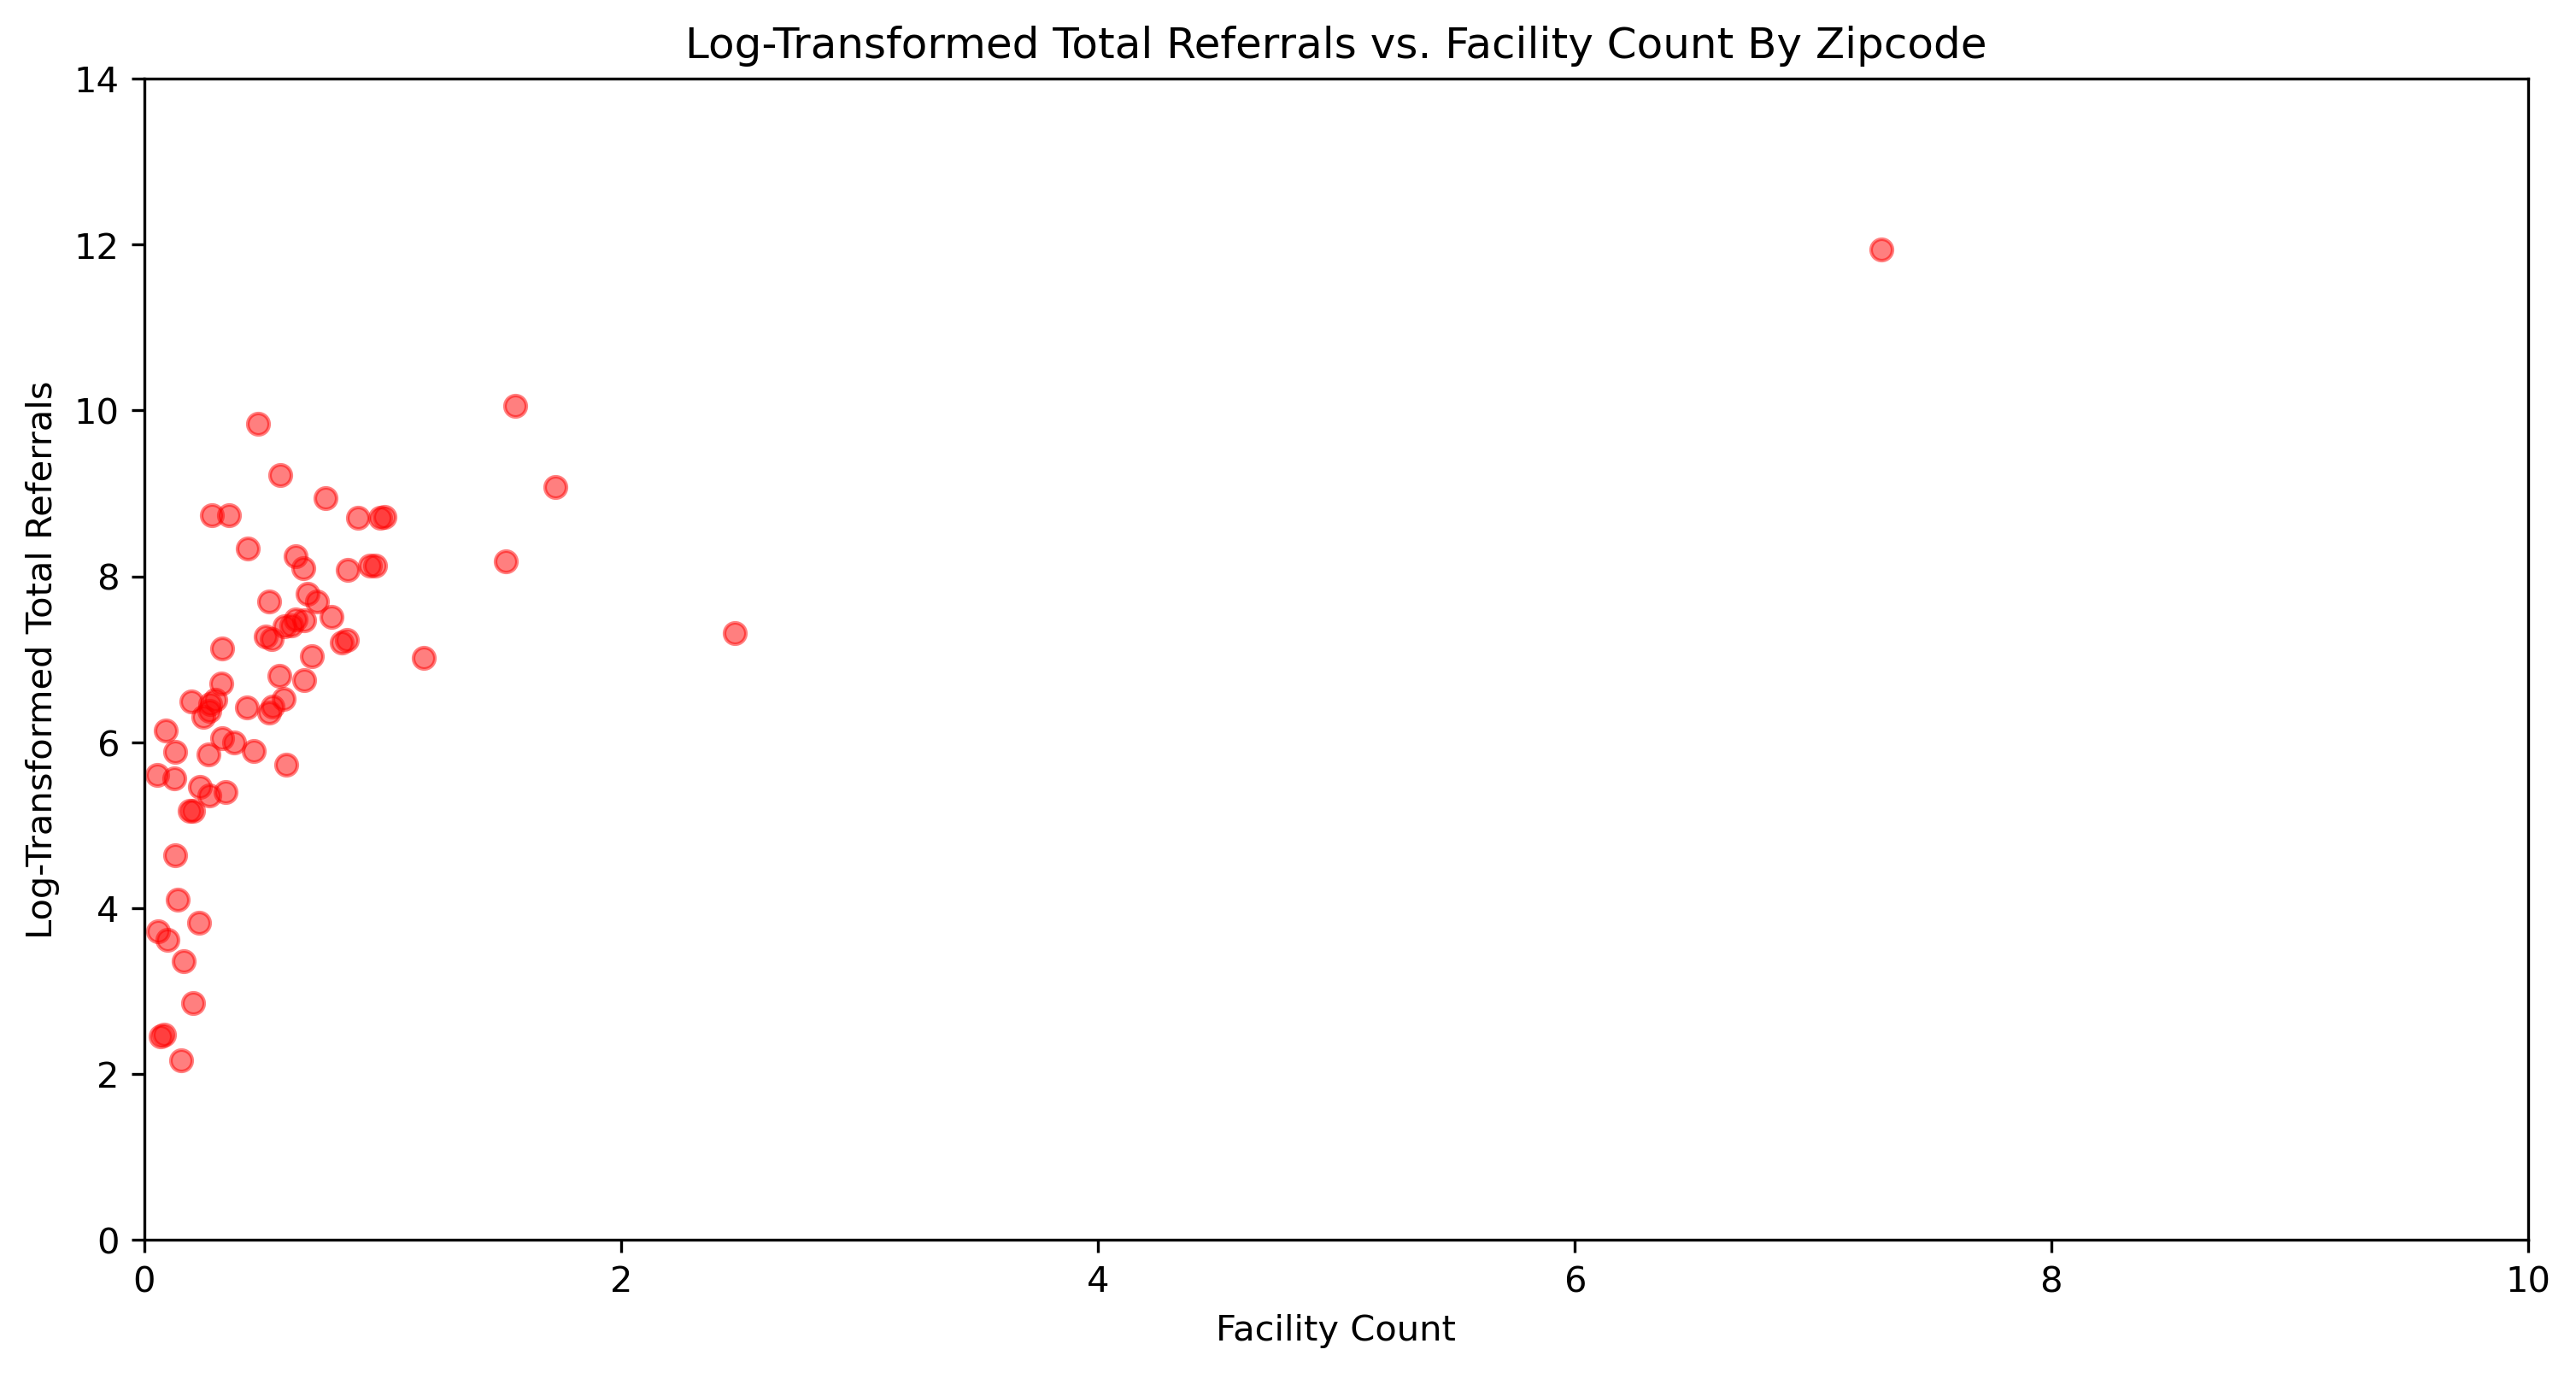

In [11]:
# Plot total referrals by zipcode against count of distinct facilities in that zipcode.
plt.figure(figsize = (12,6), dpi = 300)
plt.scatter(x = referrals_and_facilities_by_zipcode['facility_count'], 
            y = np.log(referrals_and_facilities_by_zipcode['total_referrals']),
           alpha = 0.5,
           color = 'red')
plt.title('Log-Transformed Total Referrals vs. Facility Count By Zipcode')
plt.xlabel('Facility Count')
plt.ylabel('Log-Transformed Total Referrals')
plt.xlim(0,10)
plt.ylim(0,14)
plt.show();

In [12]:
# Generate zipcodes and ratio of referrals out than referrals in.
hospital_referrals['facility_city_zipcode'] = hospital_referrals['facility_address'].str.extract('(\\d{5})')
hospital_referrals['provider_city_zipcode'] = hospital_referrals['provider_address'].str.extract('(\\d{5})')

zipcode_referrals = (
    pd.merge(hospital_referrals\
         .groupby('facility_city_zipcode')['referrals']\
         .sum()\
         .reset_index(),
         hospital_referrals\
         .groupby('provider_city_zipcode')['referrals']\
         .sum()\
         .reset_index(),
         left_on = 'facility_city_zipcode',
         right_on = 'provider_city_zipcode',
        suffixes = ('_facility','_provider'))
)

zipcode_referrals = (
    zipcode_referrals\
    .assign(referral_ratio = lambda df: df['referrals_provider']/df['referrals_facility'])\
    .rename(columns = {'facility_city_zipcode':'city_zipcode'})\
    [['city_zipcode','referral_ratio', 'referrals_provider', 'referrals_facility']]\
    .sort_values('referral_ratio', ascending = False)
)

zipcode_referrals = (
    pd.merge(zipcode_referrals,
             zipcode_pop,
             left_on = 'city_zipcode',
             right_on = 'zipcode')
)

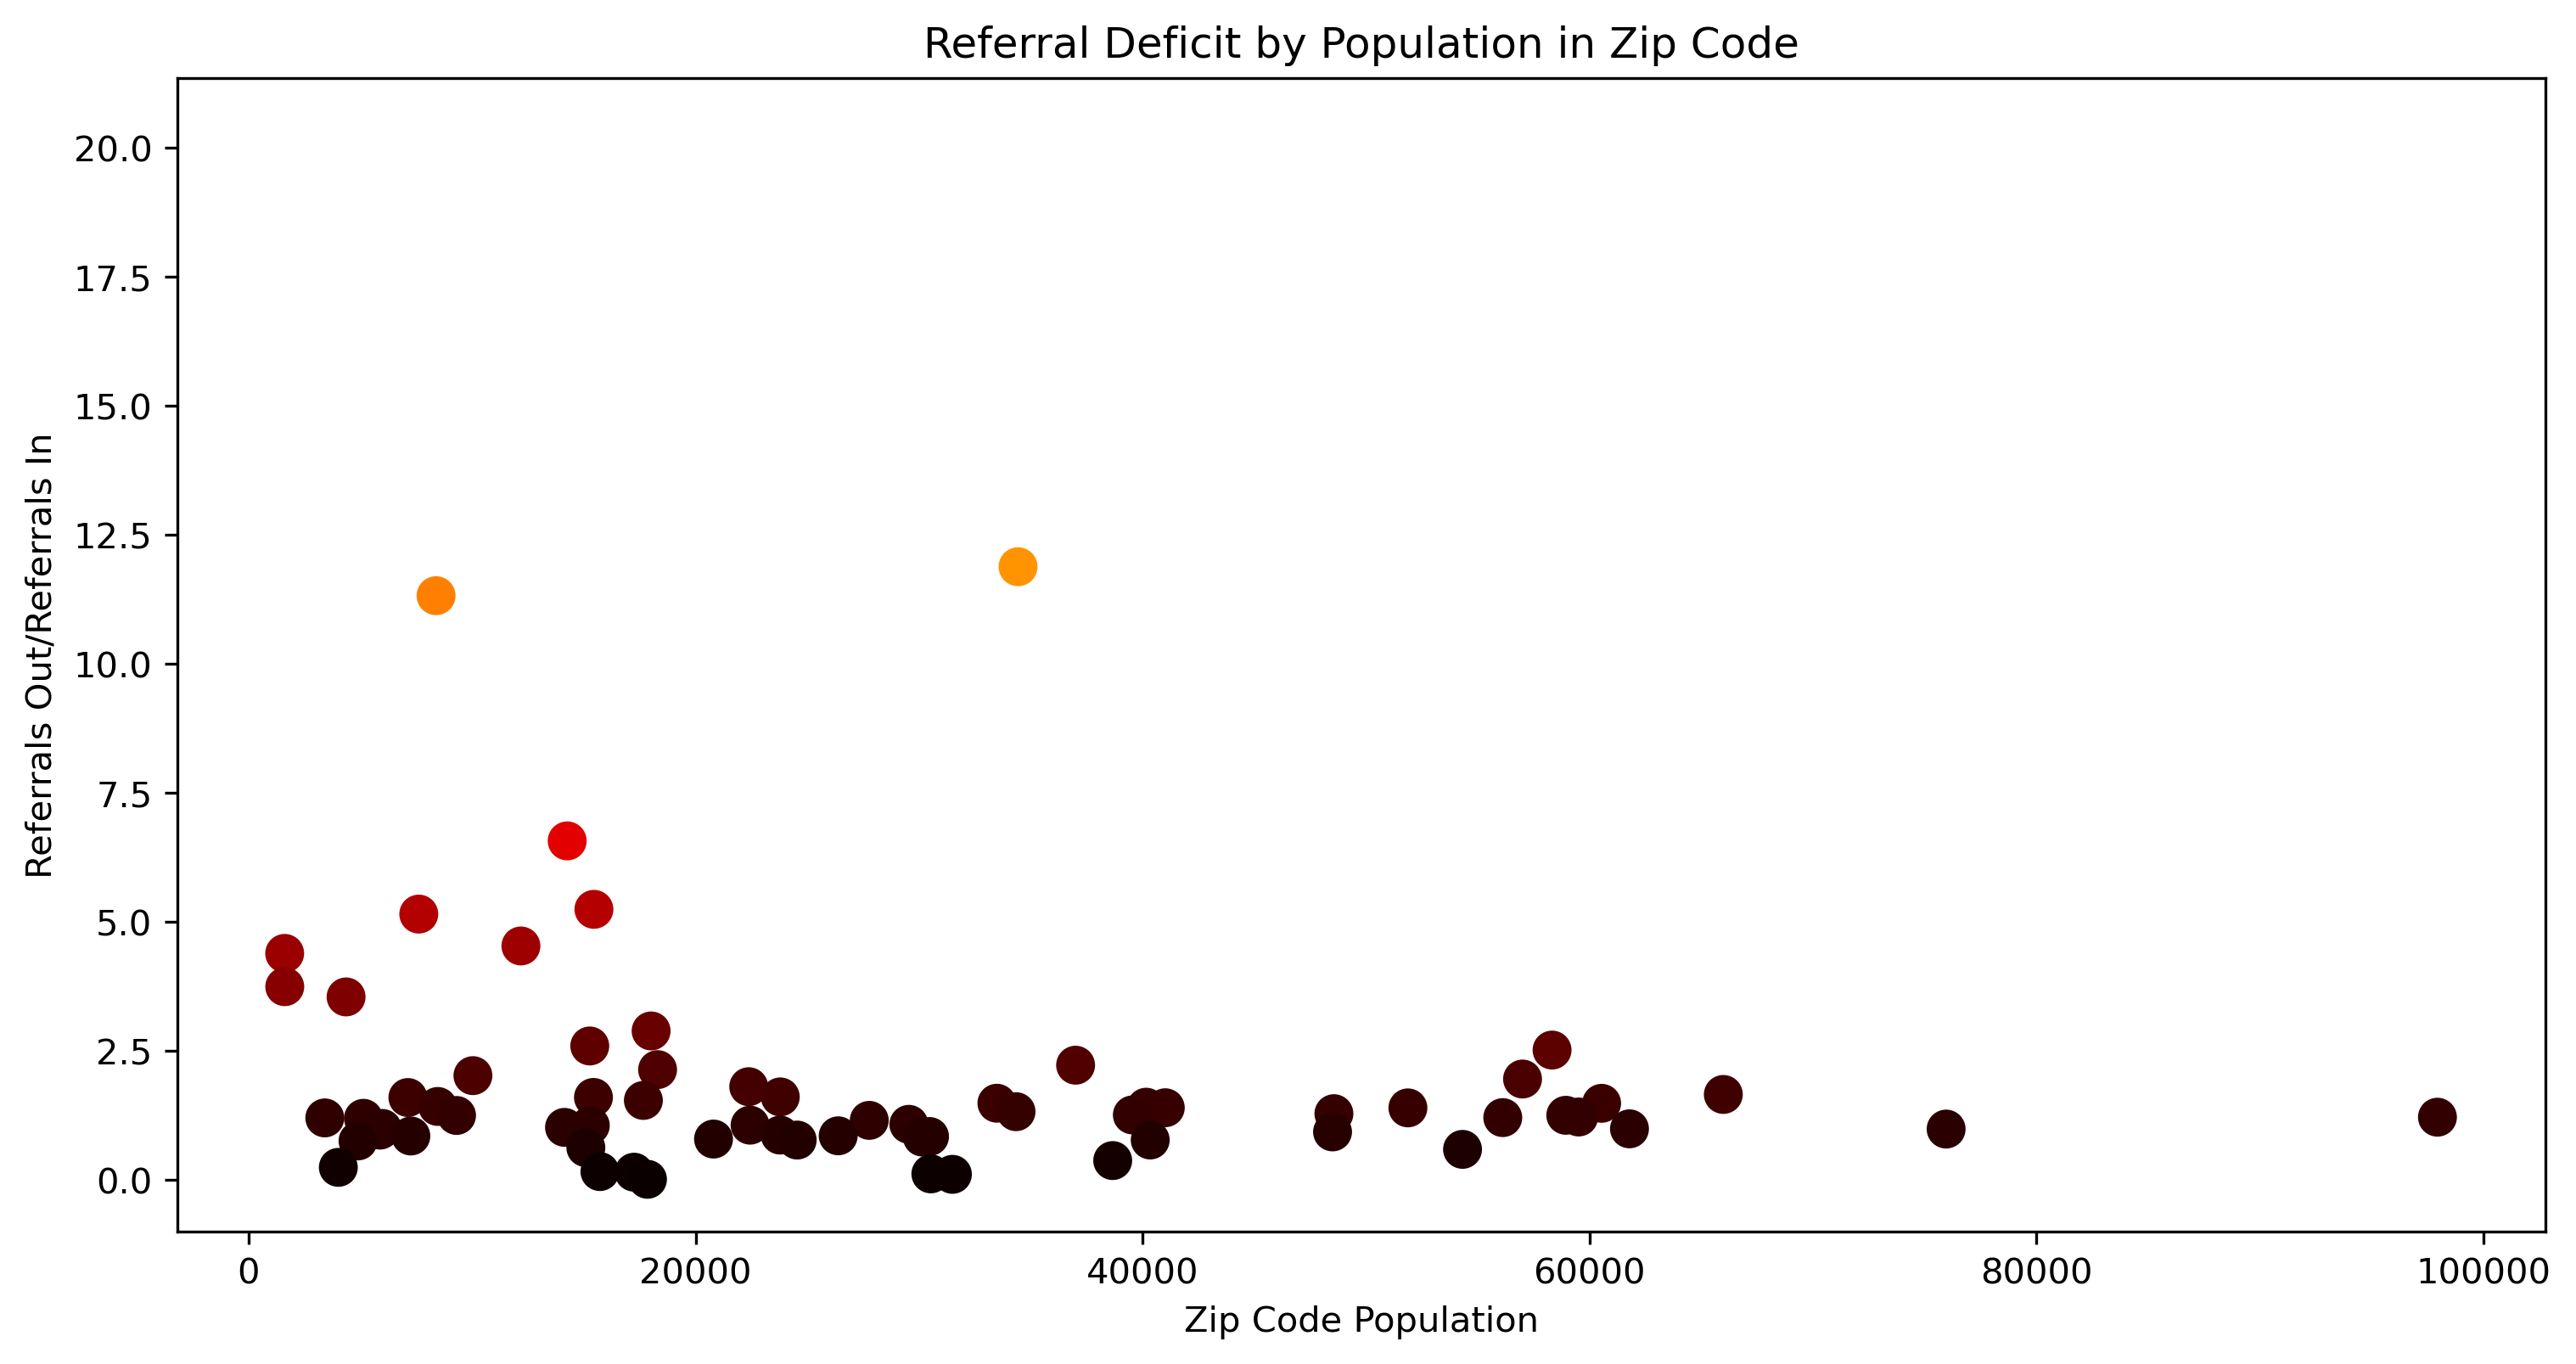

In [13]:
# Plot total referrals by zipcode against count of distinct facilities in that zipcode.
plt.figure(figsize = (12,6), dpi = 300)
plt.scatter(x = zipcode_referrals['population'], 
            y = zipcode_referrals['referral_ratio'],
            c = zipcode_referrals['referral_ratio'],
            cmap = 'hot',
            marker = 'o',
            linewidths = 5)
plt.title("Referral Deficit by Population in Zip Code")
plt.ylabel("Referrals Out/Referrals In")
plt.xlabel("Zip Code Population")
plt.show();

In [45]:
# Create dataframe where total referrals link node affiliations.
sankey_data = (
    hospital_referrals.groupby(['provider_affiliation', 'facility_affiliation'])['referrals']\
    .sum()\
    .reset_index()
)

provider_label_dict = dict(zip(sankey_data['provider_affiliation'].unique().tolist(),range(0,6)))
facility_label_dict = {k: v + 6 for k, v in provider_label_dict.items()}

In [207]:
# Create sankey plot to show affiliation links and nodes.
fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 15,
        thickness = 15,
        line = dict(color = "black", width = 0.5),
        label = ['HCA - Provider', 
                 'Nashville General Hospital - Provider', 
                 'No Major Affiliation - Provider', 
                 'Saint Thomas - Provider', 
                 'Sumner Regional - Provider', 
                 'Vanderbilt - Provider',
                 'HCA - Facility', 
                 'Nashville General Hospital - Facility', 
                 'No Major Affiliation - Facility', 
                 'Saint Thomas - Facility', 
                 'Sumner Regional - Facility', 
                 'Vanderbilt - Facility'],
        color = '#000000'
    ),
    link = dict(
        source = sankey_data['provider_affiliation'].map(provider_label_dict).tolist(),
        target = sankey_data['facility_affiliation'].map(facility_label_dict).tolist(),
        value = sankey_data['referrals'].tolist(),
        # Fix color.
        colorscales = [{"cmin": 1, "cmax": max(sankey_data['referrals'].tolist()), "colorscale": "Earth"}]
))])

fig.update_layout(title = {
    'text': "Sankey Plot of Affiliation Network",
    'y':0.9,
    'x':0.5})
fig.show()

In [98]:
no_vandy_at_all = (
    hospital_referrals\
    .loc[~hospital_referrals['provider_npi']\
         .isin(hospital_referrals['provider_npi']\
               .loc[hospital_referrals['facility_affiliation'] == 'VANDERBILT'])]\
    .groupby(['provider_affiliation','provider_taxonomy_code_display_name'])['referrals']\
    .sum()\
    .reset_index()
)

In [155]:
fig = px.sunburst(no_vandy_at_all, 
                  path = ['provider_affiliation', 'provider_taxonomy_code_display_name'], 
                  values = 'referrals',
                  color = 'referrals', 
                  color_continuous_scale = 'deep',
                  color_continuous_midpoint = np.median(no_vandy_at_all['referrals']),
                  width = 1000,
                  height = 1250,
                 title = "Specialty Breakdown for Non-Vanderbilt-Referring Providers")
fig.show()

C:\Users\charr\anaconda3\lib\site-packages\plotly\express\_core.py:1616: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\charr\anaconda3\lib\site-packages\plotly\express\_core.py:1616: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [210]:
# Generate proportions of referrals for vandy-referring providers and non-vandy-referrings providers and generate a ratio.
# Then put together 
specialty_freq = (
    pd.merge(
    hospital_referrals\
        .loc[hospital_referrals['provider_npi']\
             .isin(hospital_referrals['provider_npi']\
                   .loc[hospital_referrals['facility_affiliation'] == 'VANDERBILT'])]\
        .groupby(['provider_taxonomy_code_display_name'])['referrals']\
        .sum()\
        .reset_index()\
        .rename(columns = {'referrals':'vandy_referrals'}),
    hospital_referrals\
        .loc[~hospital_referrals['provider_npi']\
             .isin(hospital_referrals['provider_npi']\
                   .loc[hospital_referrals['facility_affiliation'] == 'VANDERBILT'])]\
        .groupby(['provider_taxonomy_code_display_name'])['referrals']\
        .sum()\
        .reset_index()\
        .rename(columns = {'referrals':'non_vandy_referrals'}),
    on = 'provider_taxonomy_code_display_name')
)

specialty_freq['non_vandy_referrals_prop'] = (
     specialty_freq['non_vandy_referrals']\
     .apply(lambda x: x/sum(specialty_freq['non_vandy_referrals']))
)

specialty_freq['vandy_referrals_prop'] = (
     specialty_freq['vandy_referrals']\
     .apply(lambda x: x/sum(specialty_freq['vandy_referrals']))
)

specialty_freq['vandy_non_vandy_referral_ratio'] = (
    specialty_freq['vandy_referrals_prop']/specialty_freq['non_vandy_referrals_prop']
)

specialty_freq_bar = (
    specialty_freq\
    .sort_values('vandy_non_vandy_referral_ratio')\
    .loc[specialty_freq['vandy_non_vandy_referral_ratio'] < 0.99]\
    .round(2)
)

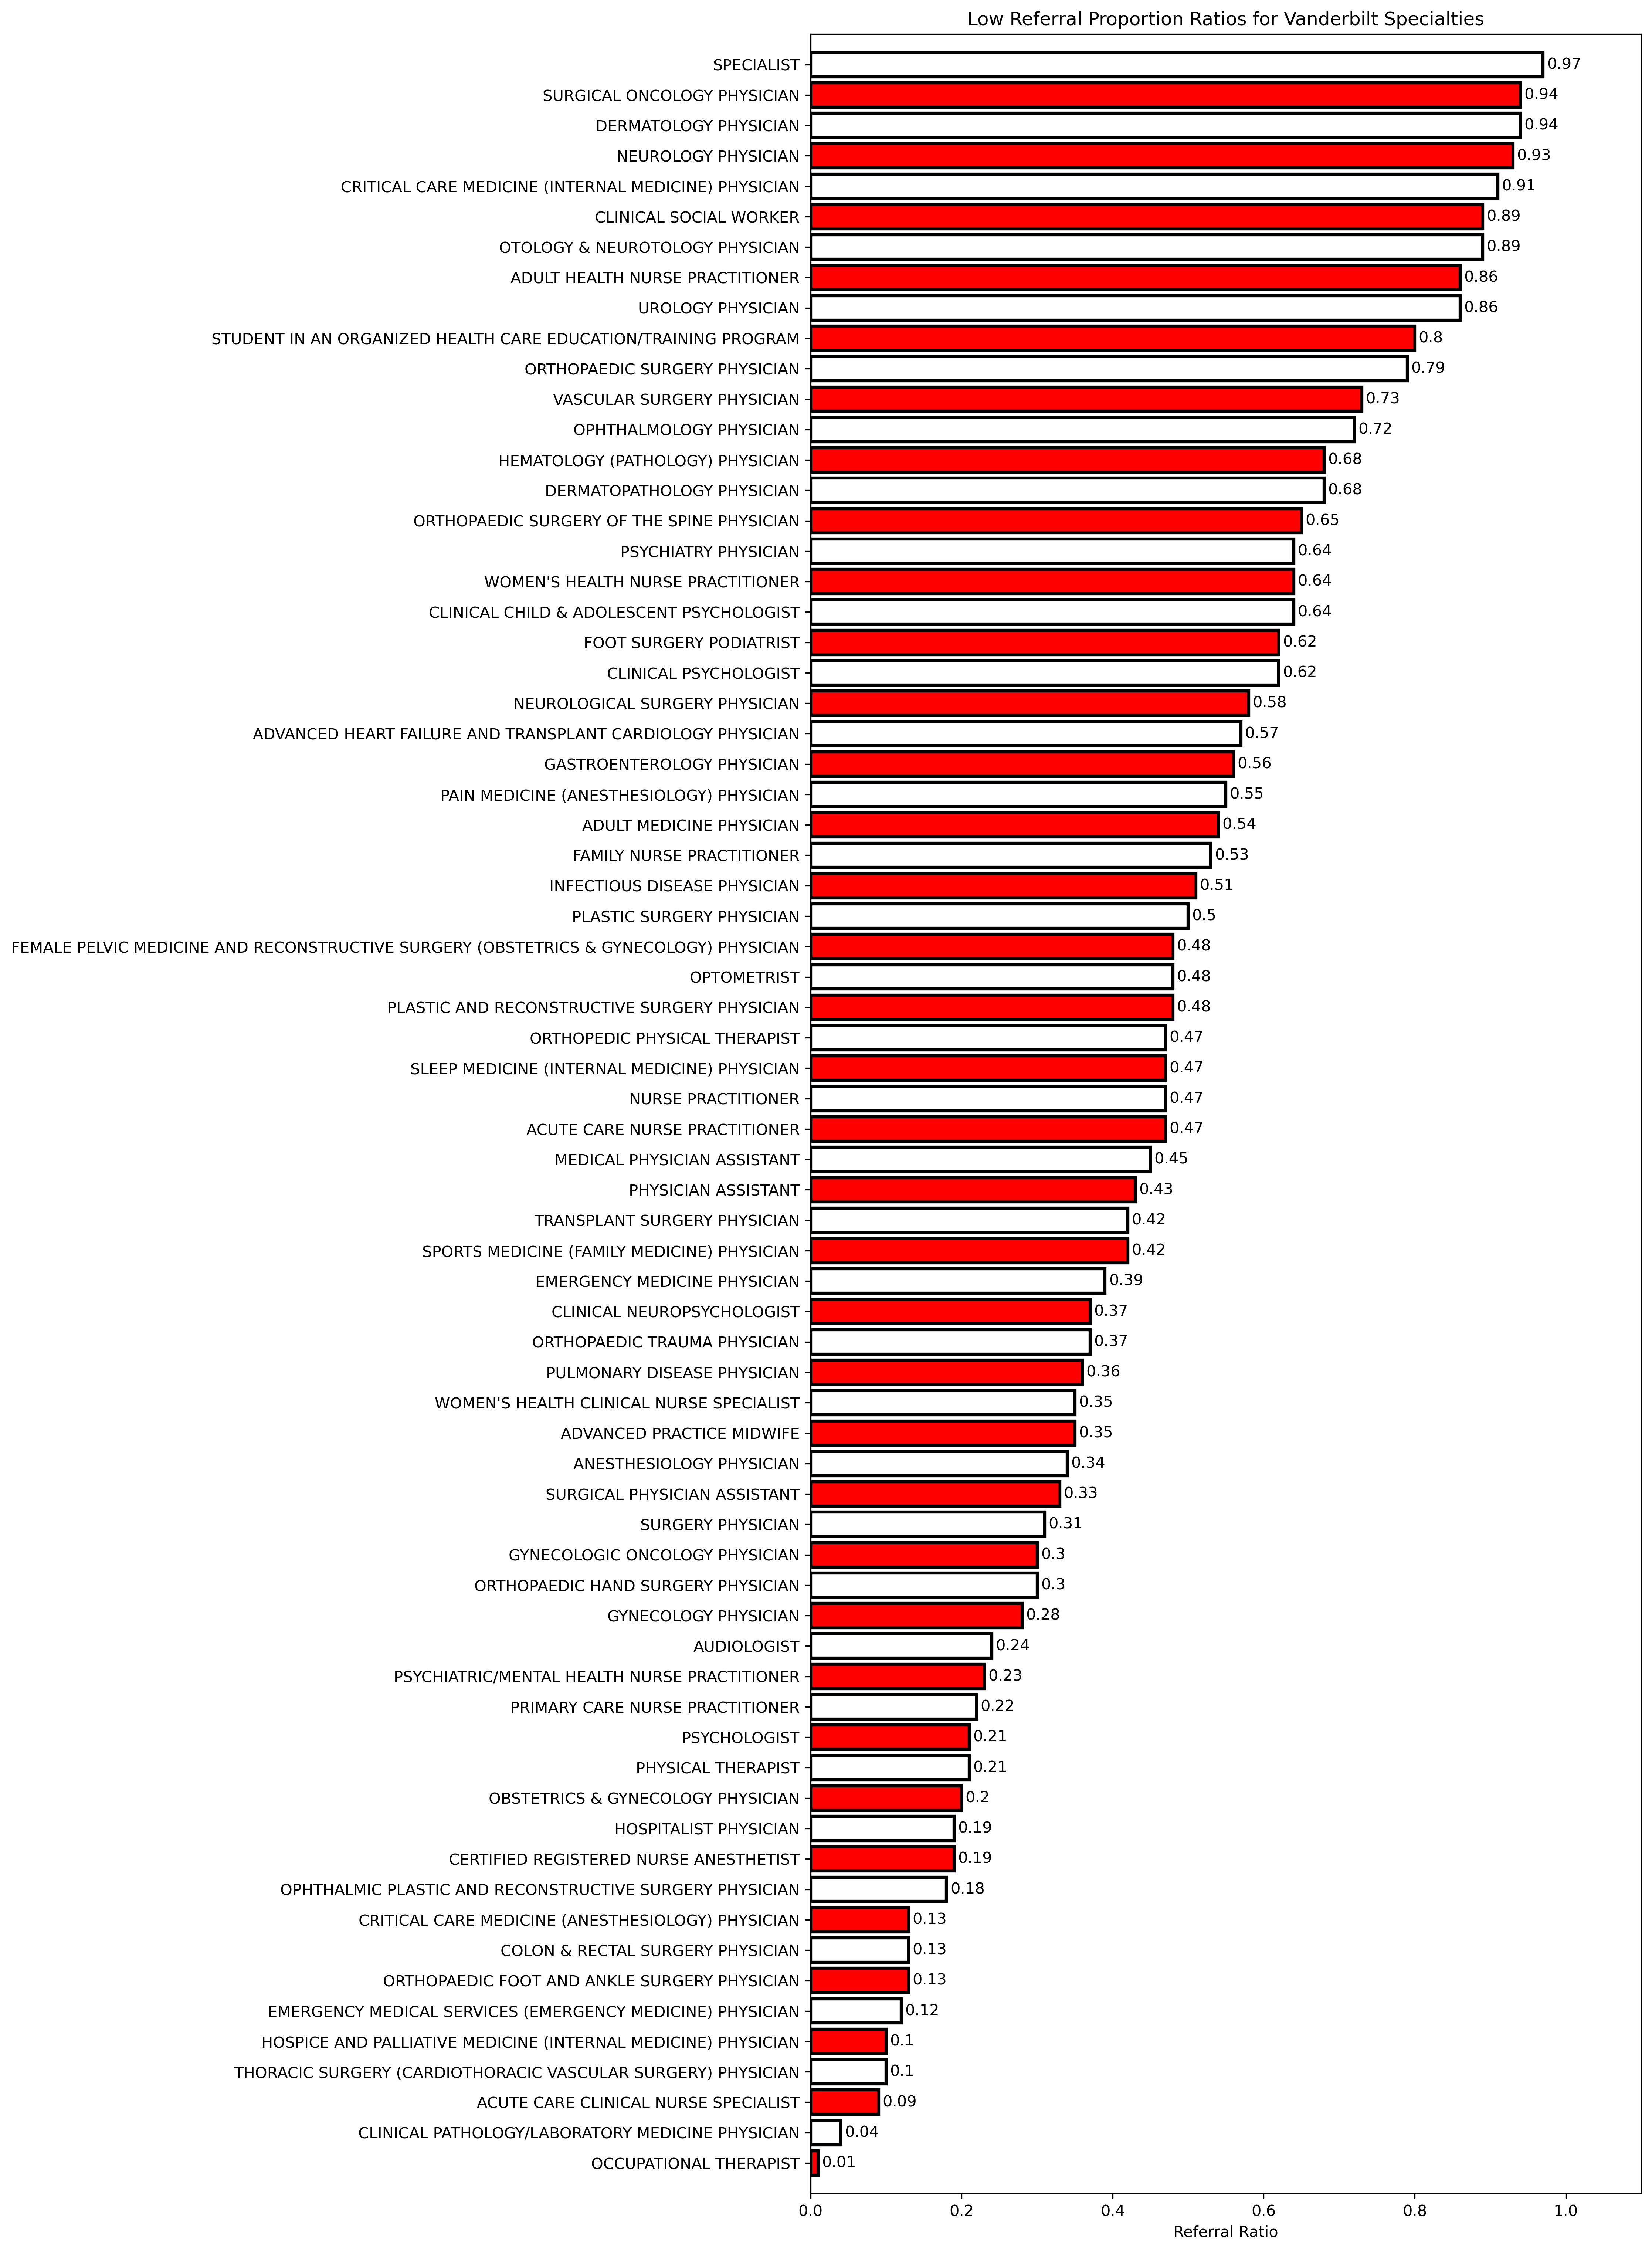

In [211]:
# Create horizontal bar chart 
fig, ax = plt.subplots(figsize = (15,20), dpi = 300)
ax.barh(width = specialty_freq_bar['vandy_non_vandy_referral_ratio'],
        y = specialty_freq_bar['provider_taxonomy_code_display_name'],
        color = ['red','white'],
        edgecolor = 'k',
        linewidth = 2)
ax.bar_label(ax.containers[0], padding = 2.5)
plt.xlim(0,1.1)
plt.ylim(-1,70)
plt.tight_layout()
plt.title("Low Referral Proportion Ratios for Vanderbilt Specialties")
plt.xlabel("Referral Ratio")
plt.show()

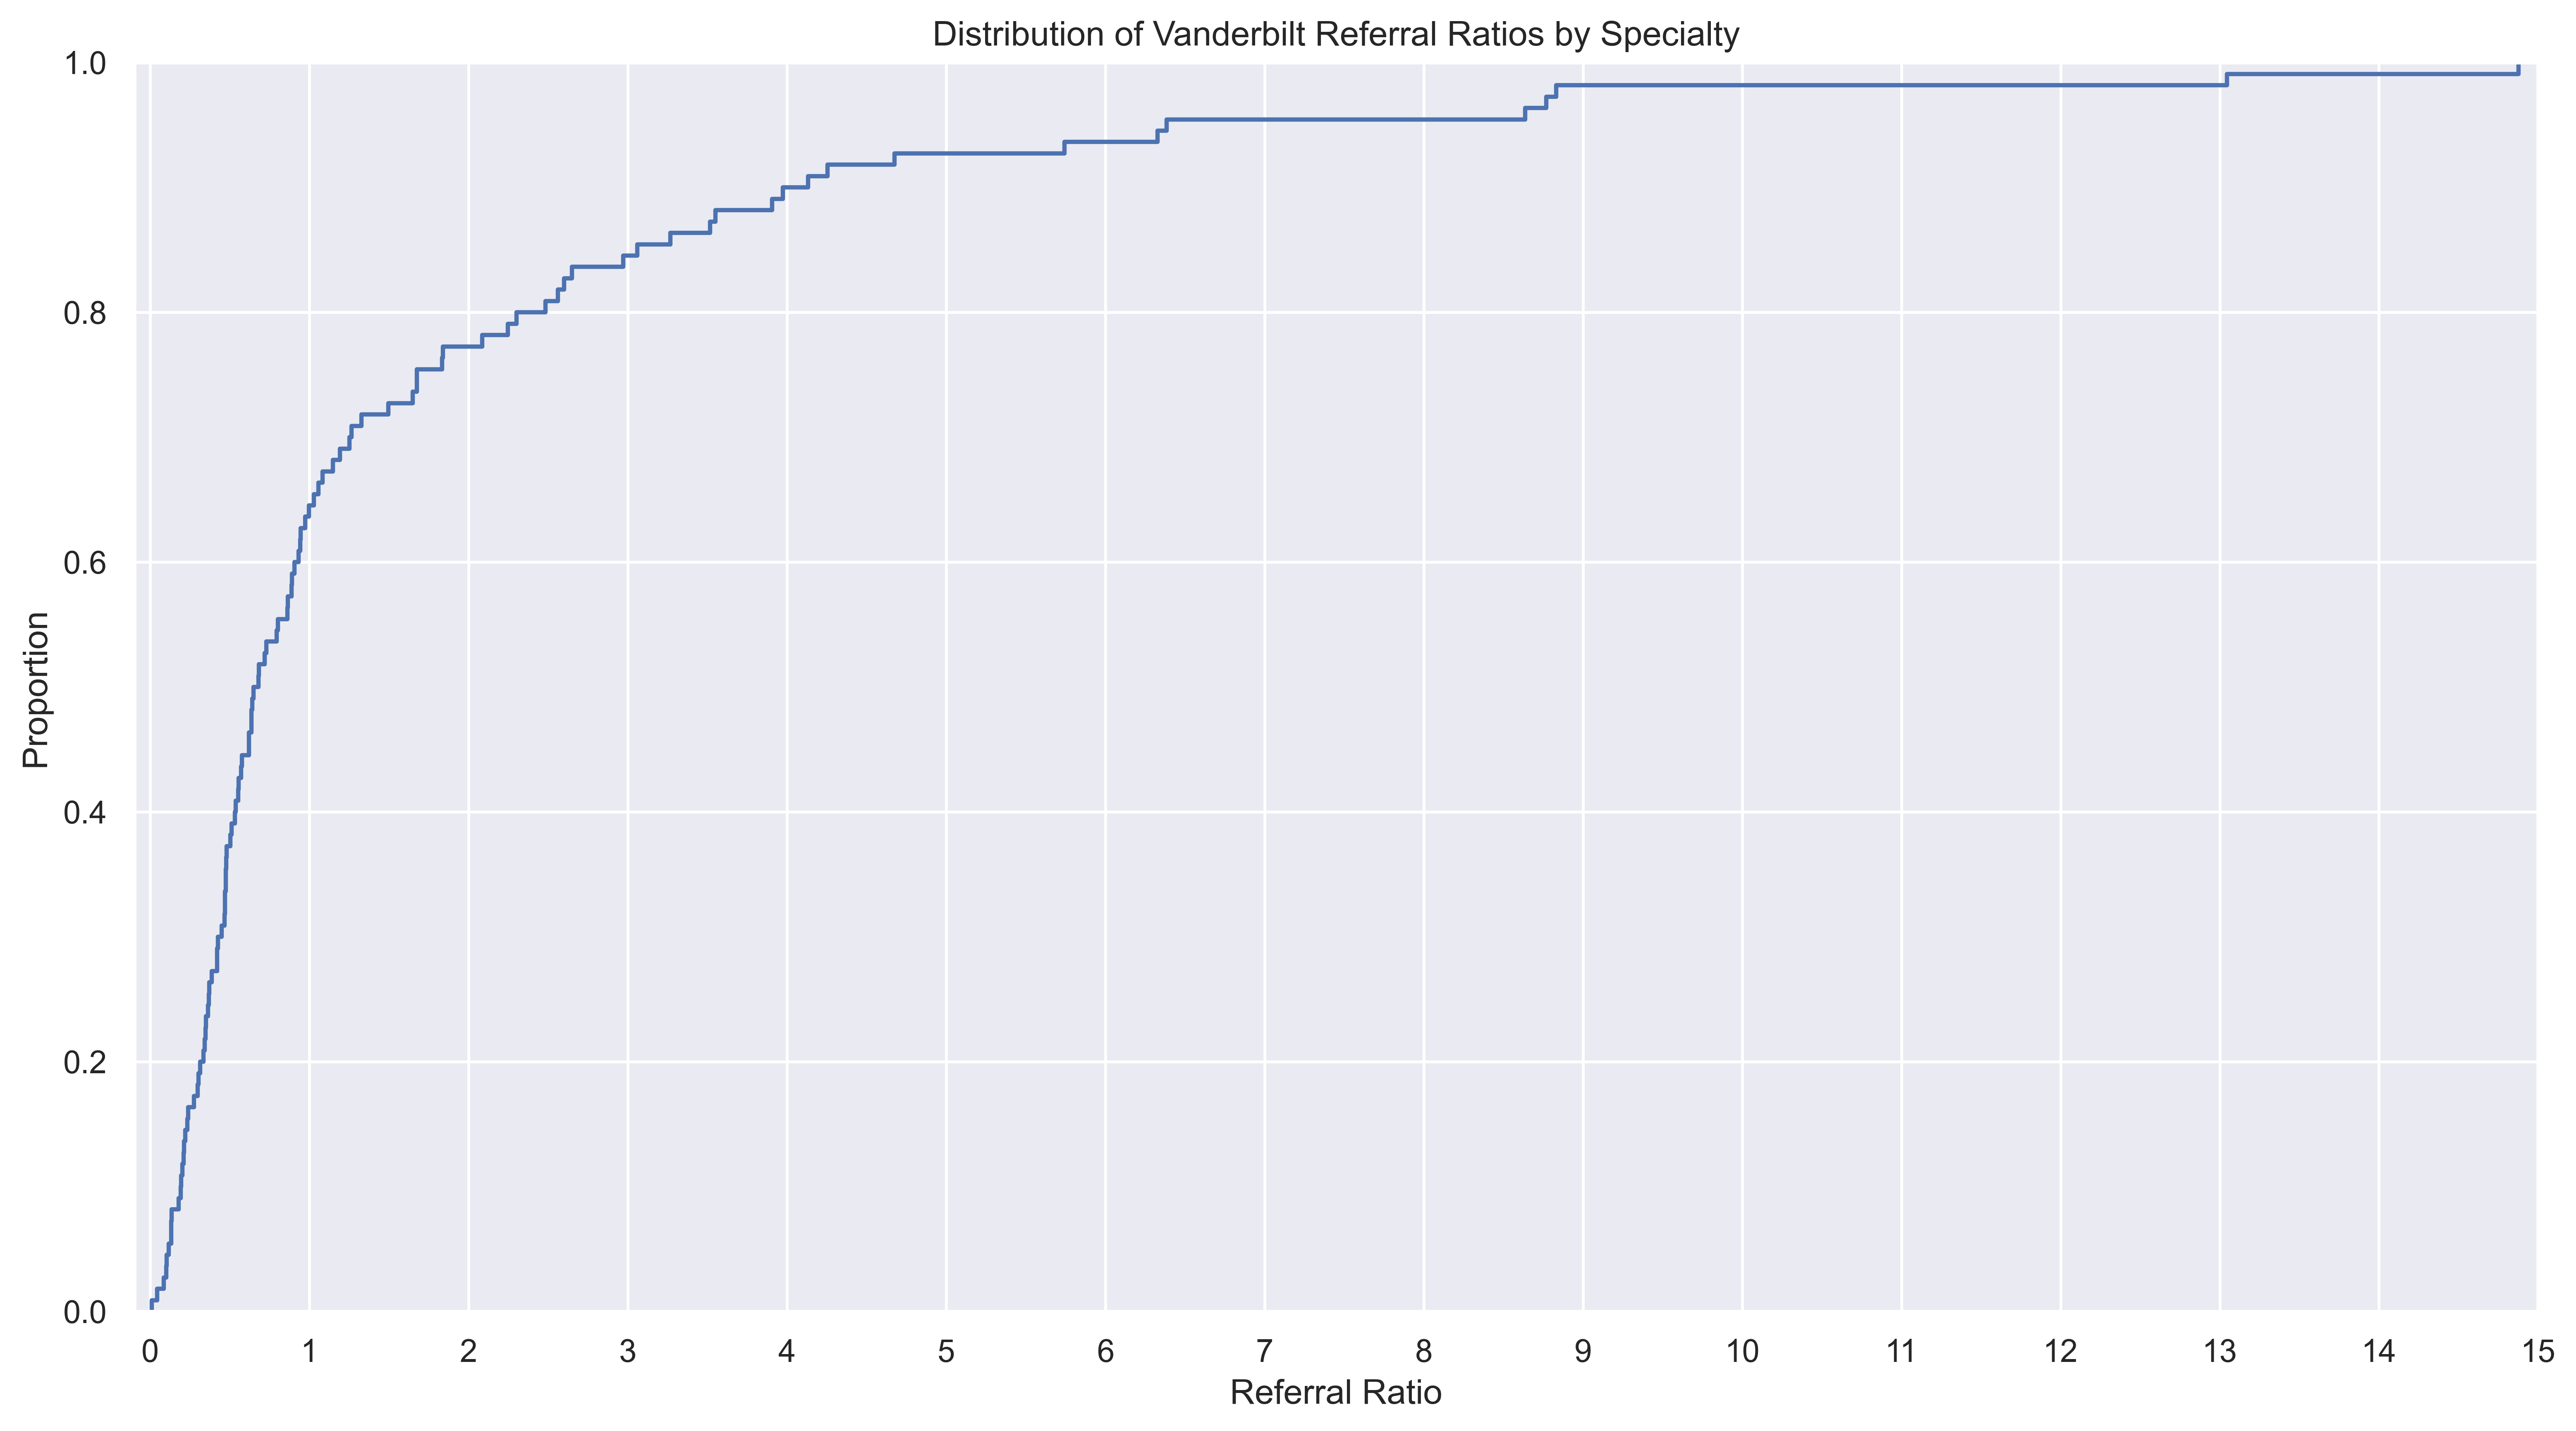

In [250]:
# Change color, set vline at 1 and corresponding hline at y-value at x = 1.
sns.set(rc = {'figure.figsize':(15,8), 'figure.dpi':500})
sns.ecdfplot(specialty_freq['vandy_non_vandy_referral_ratio'])
plt.title('Distribution of Vanderbilt Referral Ratios by Specialty')
plt.xlabel('Referral Ratio')
plt.xticks(np.arange(0,16,1))
plt.xlim(-0.1,15)
plt.ylim(0,1)
plt.show()

In [266]:
facility_specialty_freq = (
    pd.merge(
    hospital_referrals\
        .loc[hospital_referrals['facility_address']\
             .isin(hospital_referrals['facility_address']\
                   .loc[hospital_referrals['facility_affiliation'] == 'VANDERBILT'])]\
        .groupby(['facility_taxonomy_code_display_name'])['facility_address']\
        .nunique()\
        .reset_index()\
        .rename(columns = {'facility_address':'vandy_address_count'}),
    hospital_referrals\
        .loc[~hospital_referrals['facility_address']\
             .isin(hospital_referrals['facility_address']\
                   .loc[hospital_referrals['facility_affiliation'] == 'VANDERBILT'])]\
        .groupby(['facility_taxonomy_code_display_name'])['facility_address']\
        .nunique()\
        .reset_index()\
        .rename(columns = {'facility_address':'non_vandy_address_count'}),
    on = 'facility_taxonomy_code_display_name')
)

facility_specialty_freq['non_vandy_address_prop'] = (
     facility_specialty_freq['non_vandy_address_count']\
     .apply(lambda x: x/sum(facility_specialty_freq['non_vandy_address_count']))
)

facility_specialty_freq['vandy_address_prop'] = (
     facility_specialty_freq['vandy_address_count']\
     .apply(lambda x: x/sum(facility_specialty_freq['vandy_address_count']))
)

facility_specialty_freq['vandy_non_vandy_address_ratio'] = (
    facility_specialty_freq['vandy_address_prop']/facility_specialty_freq['non_vandy_address_prop']
)

In [267]:
facility_specialty_freq

,facility_taxonomy_code_display_name,vandy_address_count,non_vandy_address_count,non_vandy_address_prop,vandy_address_prop,vandy_non_vandy_address_ratio
0,AMBULATORY SURGICAL CLINIC/CENTER,1,36,0.058537,0.018519,0.316358
1,ANESTHESIOLOGY PHYSICIAN,1,8,0.013008,0.018519,1.423611
2,AUDIOLOGIST-HEARING AID FITTER,1,3,0.004878,0.018519,3.796296
3,CARDIOVASCULAR DISEASE PHYSICIAN,2,3,0.004878,0.037037,7.592593
4,COMMUNITY BASED HOSPICE CARE AGENCY,1,15,0.024390,0.018519,0.759259
5,CRITICAL ACCESS HOSPITAL,1,4,0.006504,0.018519,2.847222
6,DERMATOLOGY PHYSICIAN,1,9,0.014634,0.018519,1.265432
7,EMERGENCY MEDICINE PHYSICIAN,2,17,0.027642,0.037037,1.339869
8,END-STAGE RENAL DISEASE (ESRD) TREATMENT CLINI...,2,41,0.066667,0.037037,0.555556
9,FAMILY MEDICINE PHYSICIAN,4,84,0.136585,0.074074,0.542328
